## Libraries and variables

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.base import BaseEstimator, ClassifierMixin
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, accuracy_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import matthews_corrcoef, confusion_matrix, make_scorer

from sklearn.calibration import calibration_curve, CalibrationDisplay
from matplotlib.gridspec import GridSpec

data_path = '../01_Data/'
file_name_class = 'psp-data_class.csv'
file_path_class = data_path + file_name_class

## Data load

In [3]:
df_class = pd.read_csv(file_path_class, index_col=0)

## Split into train and test data

In [58]:
X = df_class.drop("success", axis=1)
y = df_class["success"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

## Classification

### Preparation

In [59]:
# Plot Receiver Operator Characteristics (ROC) Curve
def plot_roc(y_pred_proba, name:str):
    #y_pred_prob = classifier.predict_proba(X_test)[:, 1]

    #roc_auc = roc_auc_score(y_test, y_pred_proba)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc_value = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name + ' - ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [60]:
def grid_search_cv(estimator, params, scoring='roc_auc', cv=5, jobs=-1, verbose=3, return_train_score=True ):
    gs_cv = GridSearchCV(estimator=estimator, param_grid=params, scoring=scoring, cv=cv, n_jobs=jobs, verbose=verbose, return_train_score=return_train_score)

    gs_cv.fit(X_train, y_train)

    print(f'Best Parameter: {gs_cv.best_params_}')
    print(f'Best Score: {gs_cv.best_score_}')

In [61]:
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn = cm[1, 1]
    fp = cm[1, 0]
    return tn / (tn + fp)

In [73]:
def calc_metrics(y_pred, y_pred_proba, y_true):
    acc = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    spe = specificity_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, pos_label=0)

    return acc, mcc, auc, spe, rec

In [63]:
def print_metrics(y_pred, y_pred_proba, y_true = y_test):
    acc, mcc, auc, spe, rec = calc_metrics(y_pred, y_pred_proba, y_true=y_true)

    print("Accuracy score:", round(acc, 2))
    print("Specifity score:", round(spe, 2))
    print("Recall score:", round(rec, 2))
    print("MCC score:", round(mcc, 2))
    print("AUC score:", round(auc, 2))

### Decision Tree

In [64]:
# Find best Decistion Tree Classifier
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, 12],
    'criterion': ["gini", "entropy", "log_loss"],
    'min_samples_split': [2, 4, 8, 16],
    'min_samples_leaf': [1, 3, 5]
}

grid_search_cv(DecisionTreeClassifier(), param_grid_dt)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameter: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 16}
Best Score: 0.6570981422026456


Accuracy score: 0.8
Specifity score: 0.07
Recall score: 0.98
MCC score: 0.13
AUC score: 0.65


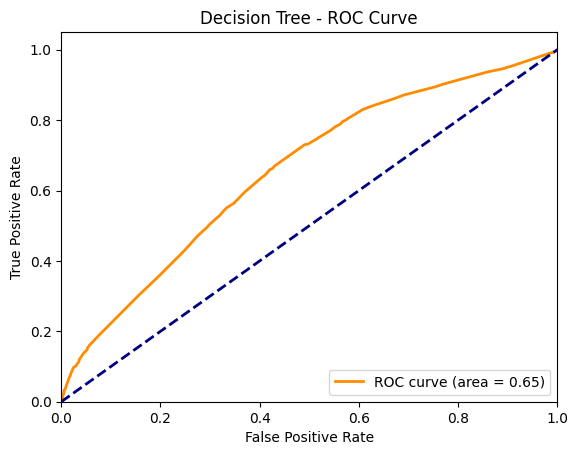

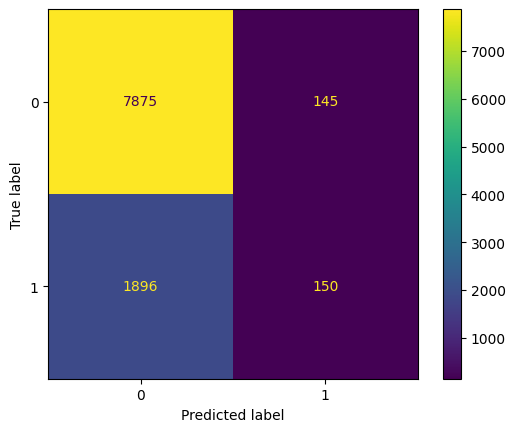

In [74]:
# Training with best model
clf_dtc = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=5, min_samples_split=16)
#clf_dtc = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_leaf=2, min_samples_split=2)
clf_dtc.fit(X_train, y_train)

# Predictions
y_pred_dtc = clf_dtc.predict(X_test)
y_pred_proba_dtc = clf_dtc.predict_proba(X_test)[:, 1]

# Evalution
print_metrics(y_pred_dtc, y_pred_proba_dtc)
plot_roc(y_pred_proba_dtc, 'Decision Tree')
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dtc)

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(clf_dtc, feature_names=X.columns, class_names=['Failure', 'Success'], filled=True, rounded=True)
plt.title('Decision Tree for Success Prediction')
plt.show()

### Random Forest

In [238]:
# Find best Random Forest Classifier
param_grid_rf = {
    'n_estimators' : [20, 50, 100],
    'max_depth': [5, 20, None],
    'criterion': ["gini", "entropy", "log_loss"],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 3, 5],
    'random_state' : [42]
}

grid_search_cv(RandomForestClassifier(), param_grid_rf)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameter: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}
Best Score: 0.6597538388752229


Accuracy score: 0.8
Specifity score: 0.02
Recall score: 1.0
MCC score: 0.09
AUC score: 0.65


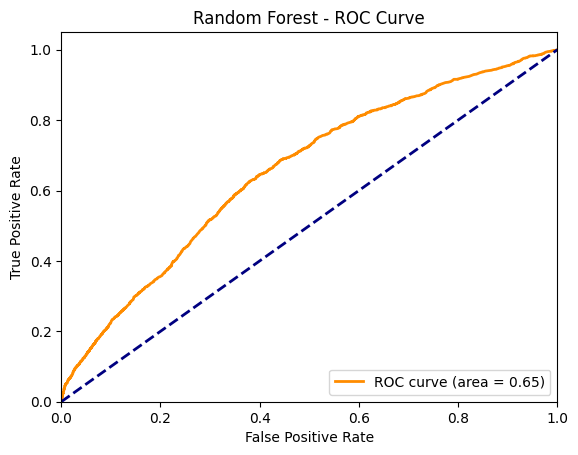

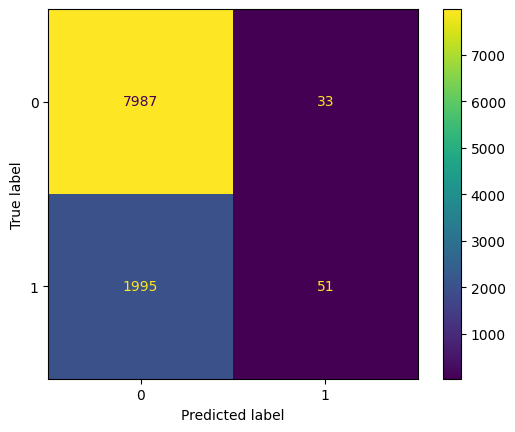

In [75]:
# Training with best model
clf_rfc = RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42)
#clf_rfc = RandomForestClassifier(n_estimators=50, criterion="gini", max_depth=None, random_state=42)
clf_rfc.fit(X_train, y_train)

# Predictions
y_pred_rf = clf_rfc.predict(X_test)
y_pred_proba_rf = clf_rfc.predict_proba(X_test)[:, 1]

# Metrics
print_metrics(y_pred_rf, y_pred_proba_rf)
plot_roc(y_pred_proba_rf, 'Random Forest')
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)

### SVC

In [8]:
param_grid_svc = {
    'C': [1, 10, 100, 200],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
}

grid_search_cv(SVC(), param_grid_svc)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameter: {'C': 200, 'gamma': 0.01, 'kernel': 'rbf'}
Best Score: 0.6258467023160884


Accuracy score: 0.79
Specifity score: 0.04
Recall score: 0.99
MCC score: 0.09
AUC score: 0.62


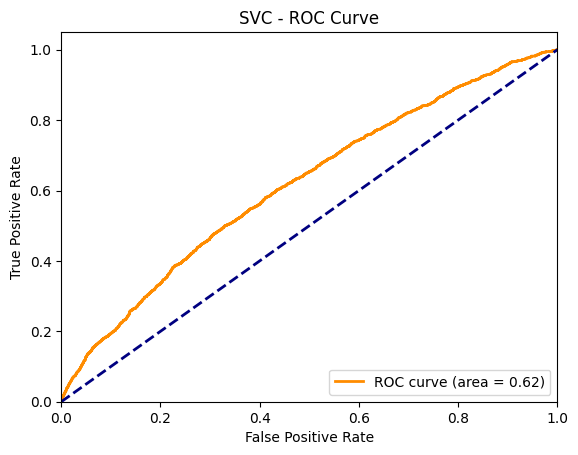

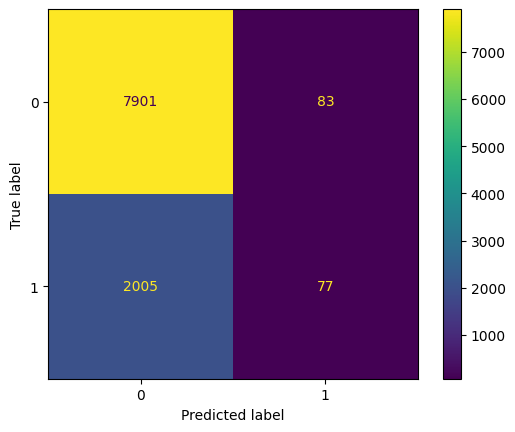

In [18]:
# Training with best model
clf_svc = SVC(probability=True, C=200, gamma=0.01, kernel='rbf')
clf_svc.fit(X_train, y_train)

# Predictions
y_pred_svc = clf_svc.predict(X_test)
y_pred_proba_svc = clf_svc.predict_proba(X_test)[:, 1]

# Evaluation
print_metrics(y_pred_svc, y_pred_proba_svc)
plot_roc(y_pred_proba_svc, 'SVC')
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc)

### Gaussian Naive Bayes

In [10]:
param_grid_gnb = {
     'var_smoothing': np.logspace(0, -9, num=100)
}

grid_search_cv(GaussianNB(), param_grid_gnb)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameter: {'var_smoothing': 1.873817422860383e-08}
Best Score: 0.609728096493358


Accuracy score: 0.78
Specifity score: 0.12
Recall score: 0.95
MCC score: 0.13
AUC score: 0.6


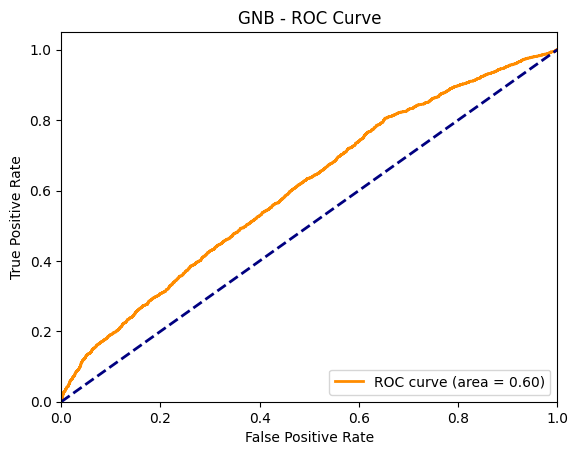

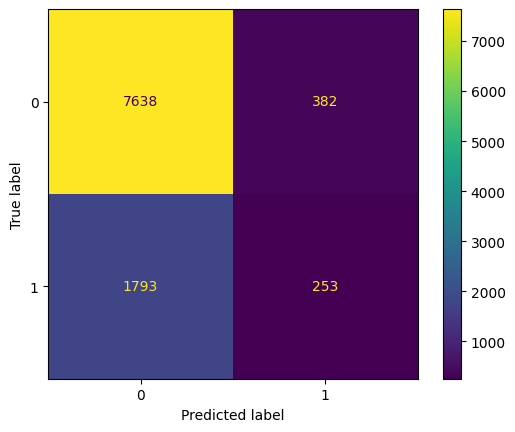

In [76]:
# Training with best model
clf_gnb = GaussianNB(var_smoothing=1.873817422860383e-08)
clf_gnb.fit(X_train, y_train)

# Predictions
y_pred_gnb = clf_gnb.predict(X_test)
y_pred_proba_gnb_full = clf_gnb.predict_proba(X_test)
y_pred_proba_gnb = clf_gnb.predict_proba(X_test)[:, 1]

# Evaluation
print_metrics(y_pred_gnb, y_pred_proba_gnb)
plot_roc(y_pred_proba_gnb, 'GNB')
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gnb)

### XGBoost

In [12]:
param_grid_xgb = {
    'objective': ['binary:logistic'],
    'max_depth': [3, 5, 7, 10, 12],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
    'n_estimators': [100, 200, 300, 400, 500],
    'colsample_bytree': [0.3, 0.7, 0.9]
}

grid_search_cv(XGBClassifier(), param_grid_xgb)

Fitting 5 folds for each of 375 candidates, totalling 1875 fits
Best Parameter: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'objective': 'binary:logistic'}
Best Score: 0.6671131837866744


Accuracy score: 0.8
Specifity score: 0.03
Recall score: 0.99
MCC score: 0.11
AUC score: 0.66


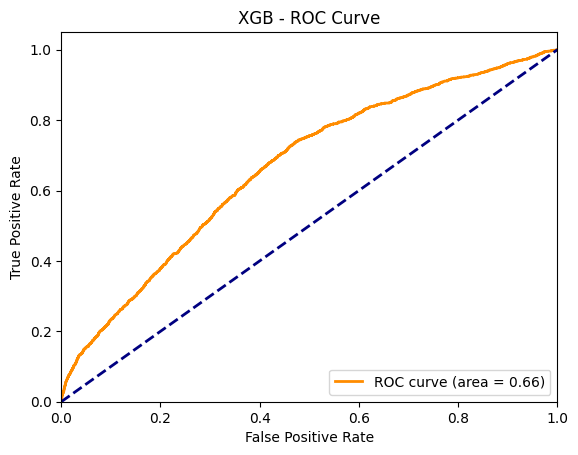

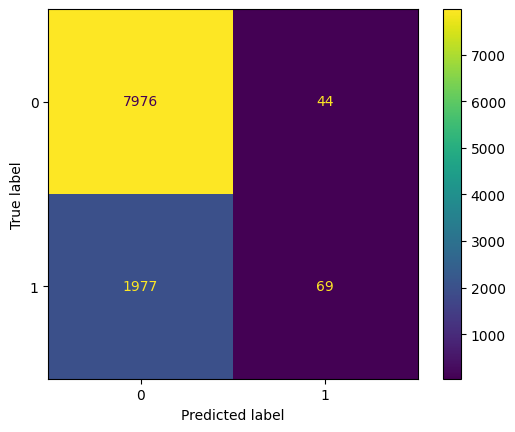

In [77]:
# Training with best model
clf_xgb = XGBClassifier(objective='binary:logistic', colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=300)
clf_xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = clf_xgb.predict(X_test)
y_pred_proba_xgb_full = clf_xgb.predict_proba(X_test)#[:, 1]
y_pred_proba_xgb = y_pred_proba_xgb_full[:, 1]

# Evaluation
print_metrics(y_pred_xgb, y_pred_proba_xgb)
plot_roc(y_pred_proba_xgb, 'XGB')
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb)

### Gaussian Mixture Model

In [14]:
class GMMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=1, covariance_type='full', init_params='kmeans', random_state=None):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.random_state = random_state
        self.init_params = init_params
        self.gmm_0 = None
        self.gmm_1 = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        X0 = X[y == 0]
        X1 = X[y == 1]
        
        self.gmm_0 = GaussianMixture(n_components=self.n_components, covariance_type=self.covariance_type, random_state=self.random_state)
        self.gmm_1 = GaussianMixture(n_components=self.n_components, covariance_type=self.covariance_type, random_state=self.random_state)
        
        self.gmm_0.fit(X0)
        self.gmm_1.fit(X1)

        return self

    def predict_proba(self, X):
        proba_0 = self.gmm_0.score_samples(X)
        proba_1 = self.gmm_1.score_samples(X)
        proba = np.exp(np.vstack([proba_0, proba_1]).T)
        return proba / proba.sum(axis=1, keepdims=True)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


In [185]:
#mcc_scorer = make_scorer(matthews_corrcoef)

In [15]:
param_grid_gmm = {
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'n_components' : [1, 2, 5, 10, 20, 40, 80],
    'random_state' : [42],
    'init_params' : ['kmeans', 'k-means++']
}

# gs_cv_gmm = GridSearchCV(estimator=GMMClassifier(), param_grid=param_grid_gmm)

# gs_cv_gmm.fit(X_train, y_train)
# print(f'Best Parameter: {gs_cv_gmm.best_params_}')
# print(f'Best Score: {gs_cv_gmm.best_score_}')
grid_search_cv(GMMClassifier(), param_grid_gmm)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Best Parameter: {'covariance_type': 'diag', 'init_params': 'kmeans', 'n_components': 80, 'random_state': 42}
Best Score: 0.6539823699178473


Accuracy score: 0.6
Specifity score: 0.63
Recall score: 0.59
MCC score: 0.18
AUC score: 0.65


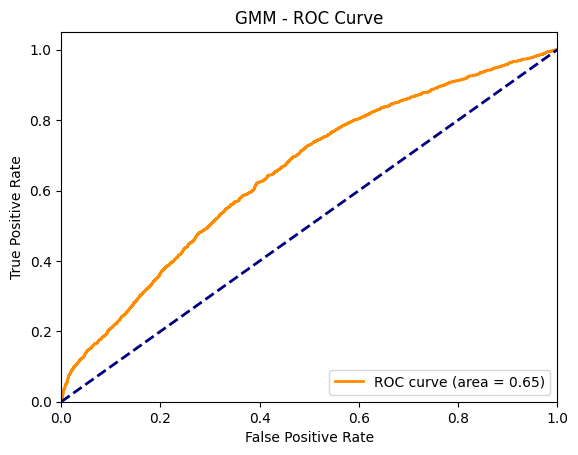

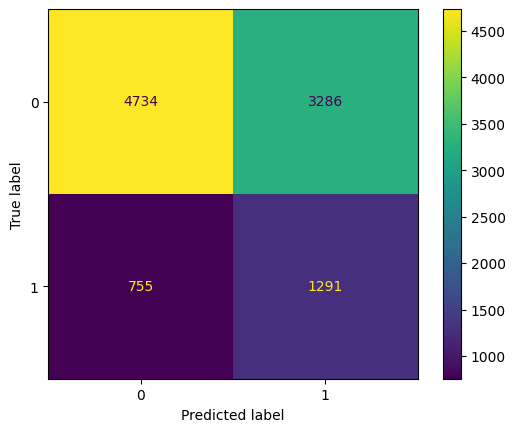

In [78]:
# Training with best model
# clf_gmm = GMMClassifier(n_components=1, covariance_type='spherical', random_state=42)
clf_gmm = GMMClassifier(n_components=80, covariance_type='diag', random_state=42)
clf_gmm.fit(X_train, y_train)

# Predictions
y_pred_gmm = clf_gmm.predict(X_test)
y_pred_proba_gmm_full = clf_gmm.predict_proba(X_test)#[:, 1]
y_pred_proba_gmm = y_pred_proba_gmm_full[:, 1]

# Evaluation
print_metrics(y_pred_gmm, y_pred_proba_gmm)
plot_roc(y_pred_proba_gmm, 'GMM')
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gmm)

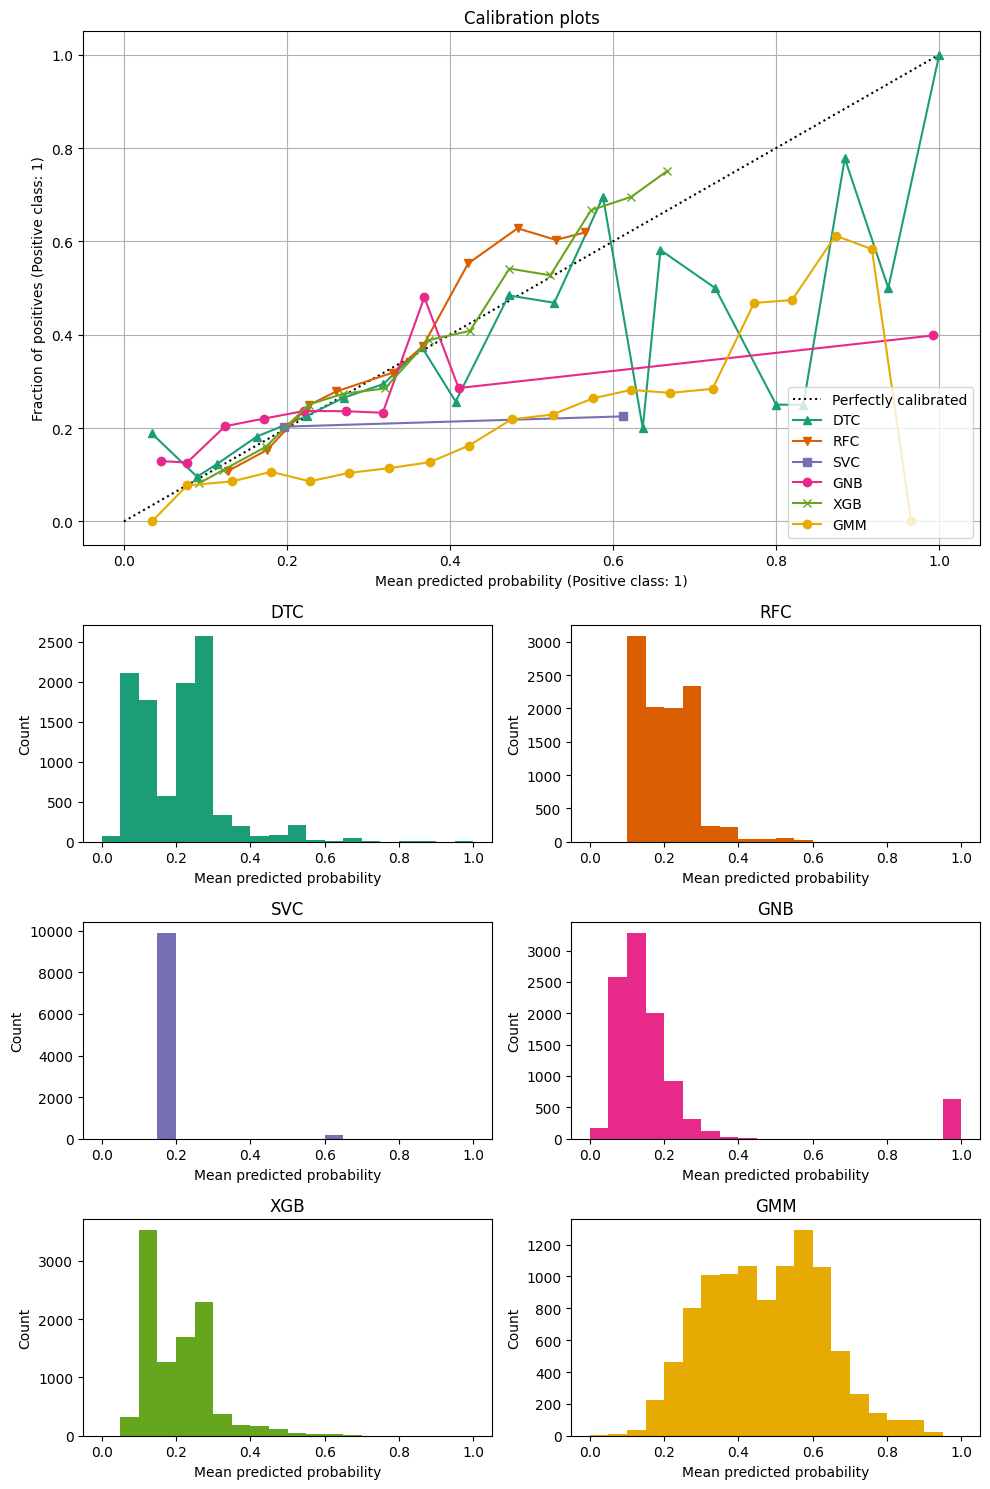

In [86]:
clf_list = [
    (y_pred_proba_dtc, "DTC"),
    (y_pred_proba_rf, "RFC"),
    (y_pred_proba_svc, "SVC"),
    (y_pred_proba_gnb, "GNB"),
    (y_pred_proba_xgb, "XGB"),
    (y_pred_proba_gmm, "GMM")
]

fig = plt.figure(figsize=(10, 15))
gs = GridSpec(5, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o", "x", "o"]
for i, (y_pred, name) in enumerate(clf_list):
    display = CalibrationDisplay.from_predictions(
        y_test,
        y_pred,
        n_bins=20,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4,1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=20,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

## Ensemble

TODO: Cross Validation für Ensemble durchführen

Accuracy score: 0.79
Specifity score: 0.14
Recall score: 0.95
MCC score: 0.16
AUC score: 0.66


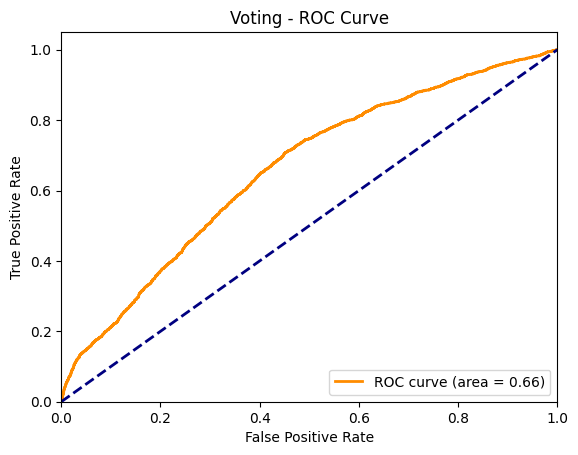

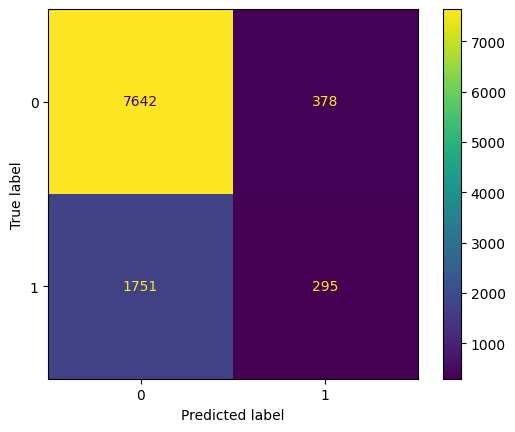

In [90]:
from sklearn.ensemble import VotingClassifier

# Voting Classifier erstellen
voting_clf = VotingClassifier(estimators=[
    # ('cl1', clf_rfc),
    # ('cl2', clf_xgb),
    # ('cl3', clf_gnb),
    ('cl4', clf_dtc),
    ('cl5', clf_gmm)
], voting='soft')  # Verwenden von 'soft' voting um Wahrscheinlichkeiten zu kombinieren

# Training
voting_clf.fit(X_train, y_train)

# Vorhersage
y_pred_vot = voting_clf.predict(X_test)
y_pred_proba_vot = voting_clf.predict_proba(X_test)[:,1]

# Metrics
print_metrics(y_pred_vot, y_pred_proba_vot)
plot_roc(y_pred_proba_vot, 'Voting')
_ = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_vot)

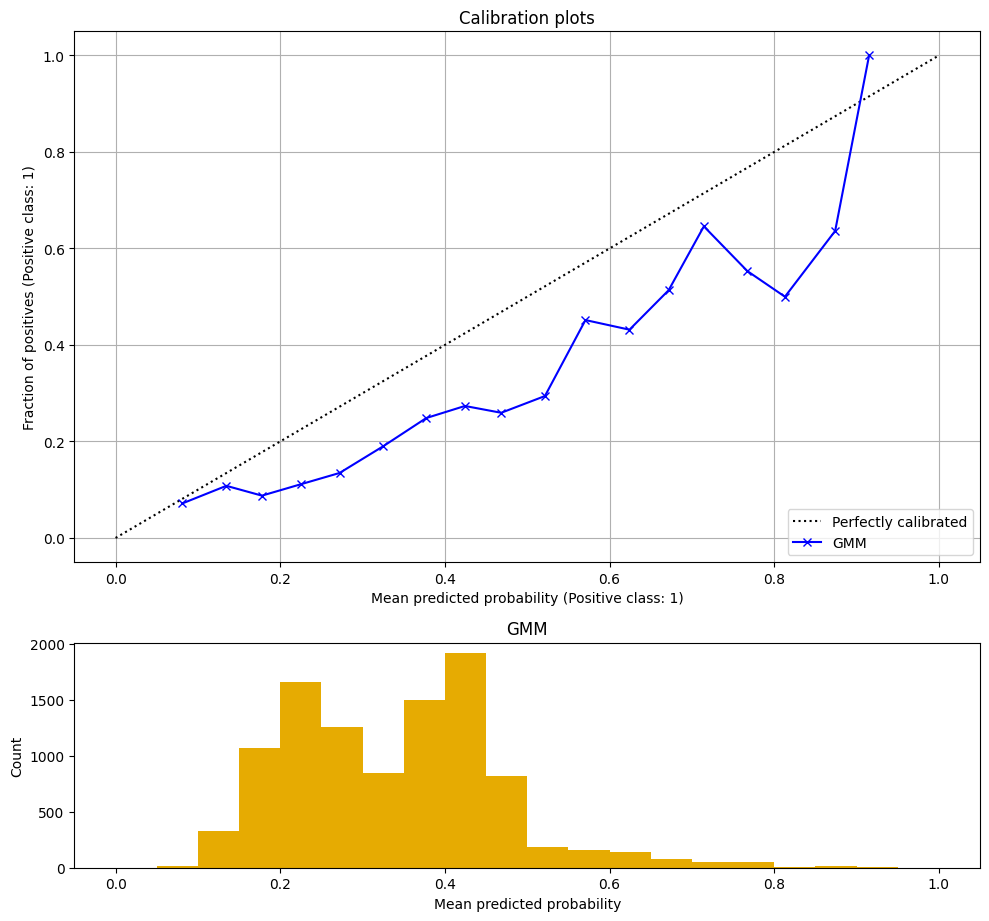

In [97]:
fig = plt.figure(figsize=(10, 15))
gs = GridSpec(5, 1)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
#calibration_displays = {}

display = CalibrationDisplay.from_predictions(
    y_test,
    y_pred_proba_vot,
    n_bins=20,
    name=name,
    ax=ax_calibration_curve,
    color="blue",
    marker="x"
)
calibration_displays["Ensemble"] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4,1)]

row, col = grid_positions[i]
ax = fig.add_subplot(gs[2, 0])
#ax = fig.add_subplot()

ax.hist(
    calibration_displays["Ensemble"].y_prob,
    range=(0, 1),
    bins=20,
    label=name,
    color=colors(i),
)
ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()